# Feature Selection for scRNA-seq Analysis
This notebook shows how to perform feature selection on a sample scRNA-seq dataset which contains 17 clusters and each cluster contains 20 genes.

We first find independent features by removing features that are dependent on other features. During this process, Seqbatch and Brain region features are removed which are dependent on Capbatch.

We next perform feature selection using two approaches:  
- Top down: we start with full feature set and remove one feature from the feature set at each iteration.  
- Bottom up: we start with empty set and add one feature into the feature set at each iteration.


In [1]:
from models.poi import Poi
from models.nb import NB
from models.poih import PoiH
from models.nbh import NBH
from models.zipoi import ZIPoi
from models.zinb import ZINB
from models.mast import MAST

import numpy as np
import pandas as pd
import time
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from utils import find_independent_features,gen_feature_df,remove_list
from tensorzinb.utils import correct_pvalues_for_multiple_testing,normalize_features
from lrtest import LRTest

plt.style.use('ggplot')

# Model description

`model_classes` defines supported models and `methods` defines the supported methods for each model. You can choose the model from `model_classes` and its corresponding supported methods from `methods` for feature selection.

In [2]:
model_classes = [Poi, NB, PoiH, NBH, ZIPoi, ZINB, MAST]

methods={
    Poi: ['stan','statsmodels'],
    NB: ['stan','statsmodels','tensorflow'],
    PoiH: ['stan','statsmodels'],
    NBH: ['stan','statsmodels'],
    ZIPoi: ['stan','statsmodels'],
    ZINB: ['stan','statsmodels','tensorflow'],
    MAST: ['statsmodels'],
}

# Clean up features

## load data

In [3]:
df_g = pd.read_csv('./data/model_sel_genes.csv')
df_m = pd.read_csv('./data/meta.zip',sep='\t')
df_m.set_index('cell', inplace=True)
columns = {"post-mortem interval (hours)": "PMI", "RNA Integrity Number": "RIN", "RNA ribosomal percent": "ribo_pct", "RNA mitochondr. percent": "mito_pct"}
df_feature = df_m.rename(columns=columns)
df =  pd.read_csv('./data/model_sel_count.zip').set_index('cell')


## generate additional features

In [4]:
df_feature['genes_log'] = np.log(df_feature['genes'])
df_feature['UMIs_log'] = np.log(df_feature['UMIs'])
df_feature['scaler'] = 10000.0/df_feature['UMIs']

## find independent features

In [5]:
features = ['region', 'age', 'sex', 'diagnosis',
       'Capbatch', 'Seqbatch', 'PMI', 'RIN', 'genes', 'UMIs', 'mito_pct',
       'ribo_pct', 'genes_log', 'UMIs_log']
conditions = ['diagnosis']
ind_features = find_independent_features(df_feature,features,keep_cols=conditions)

In [6]:
ind_features

['age',
 'sex',
 'Capbatch',
 'PMI',
 'RIN',
 'genes',
 'UMIs',
 'mito_pct',
 'ribo_pct',
 'genes_log',
 'UMIs_log']

In [7]:
len(ind_features),len(features)

(11, 14)

In [8]:
set(features)-set(ind_features+conditions)

{'Seqbatch', 'region'}

In [9]:
df0=gen_feature_df(df_feature,features)
df1=gen_feature_df(df_feature,ind_features+conditions)
np.linalg.matrix_rank(df0),np.linalg.matrix_rank(df1)

(19, 19)

Capbatch uniquely determines Seqbatch, and Capbatch CB3, CB4, CB8, CB9 uniquely determines the Brain region.

In [10]:
df0=gen_feature_df(df_feature,['Capbatch','region'])
df1=gen_feature_df(df_feature,['Capbatch'])
np.linalg.matrix_rank(df0),np.linalg.matrix_rank(df1)

(8, 8)

In [11]:
df0=gen_feature_df(df_feature,['Capbatch','Seqbatch'])
df1=gen_feature_df(df_feature,['Capbatch'])
np.linalg.matrix_rank(df0),np.linalg.matrix_rank(df1)

(8, 8)

# Feature selection

## Prepare data

In [12]:
def get_metric(
    model_class,
    method,
    dfs_data,
    dfs_feature,
    exog_features,
    exog_features_infl,
    conditions,
    scaler_col,
):
    n = len(dfs_data)
    res = []
    for i in range(n):
        lrtest = LRTest(
            model_class,
            dfs_data[i],
            dfs_feature[i],
            conditions,
            exog_features,
            infl_features=exog_features_infl,
            scaler_col=scaler_col,
        )

        r = lrtest.run_condition(method=method)
        res = res + r
    dfr=pd.DataFrame(res)
    return dfr

def map_idx_feature(features, idxs, M=2):
    sel_features = []
    n_features = len(features)
    for j in range(M):
        sel = [features[i-j*n_features] for i in idxs if i>=j*n_features and i<(j+1)*n_features]
        sel_features.append(sel)
    return sel_features

In [13]:
n_feature = len(ind_features)
scaler_col='scaler'
features_to_norm = [
    "UMIs",
    "genes",
    "UMIs_log",
    "genes_log",
    "age",
    "PMI",
    "RIN",
    "ribo_pct",
    "mito_pct",
]

In [14]:
# # This is a small dataset if you want to try
# clusters = df_g.cluster.unique()[:2]
# dfs_data = []
# dfs_feature = []
# for cluster in clusters:
#     gene_ids = df_g[df_g.cluster == cluster].gene_id.values[:1]

#     df_feature1 = df_feature[df_feature.cluster == cluster].copy()
#     df_feature1 = normalize_features(df_feature1, features_to_norm)
#     df_data = pd.merge(
#         df[gene_ids], df_feature1.reset_index()[["cell"]], on="cell"
#     ).set_index("cell")
    
#     dfs_data.append(df_data)
#     dfs_feature.append(df_feature1)

In [15]:
clusters = df_g.cluster.unique()
dfs_data = []
dfs_feature = []
for cluster in clusters:
    gene_ids = df_g[df_g.cluster == cluster].gene_id.values

    df_feature1 = df_feature[df_feature.cluster == cluster].copy()
    df_feature1 = normalize_features(df_feature1, features_to_norm)
    df_data = pd.merge(
        df[gene_ids], df_feature1.reset_index()[["cell"]], on="cell"
    ).set_index("cell")
    
    dfs_data.append(df_data)
    dfs_feature.append(df_feature1)

In [16]:
model_class = ZINB
method = 'tensorflow'

# model_class = MAST
# method = 'statsmodels'

## Top down approach

in this approach, we start with the full feature set and remove one feature from the feature set at each iteration

In [17]:
def top_down_each(
    ind_features,
    feature_idxs,
    dfs_data,
    dfs_feature,
    model_class,
    method,
    conditions,
    scaler_col,
):
    feature_idxs = list(feature_idxs)
    res = []
    for idx in feature_idxs:
        # remove a feature each time
        cur_idxs = remove_list(feature_idxs, [idx])
        sel_features = map_idx_feature(ind_features, cur_idxs)
        dfr = get_metric(
            model_class,
            method,
            dfs_data,
            dfs_feature,
            sel_features[0],
            sel_features[1],
            conditions,
            scaler_col,
        )
        r = {}
        r["aic"] = dfr["aic"].sum()
        r["llf"] = dfr["llf"].sum()
        r["idxs"] = cur_idxs
        res.append(r)
    return res

In [18]:
import datetime

suffix = datetime.date.today().strftime("%m_%d_%Y")
pickle_name = "feature_selection_topdown_{}_{}_{}.pickle".format(model_class.__name__,method,suffix)

TODO: early stop feature selection if no AIC improvement or even decrease after certain number of iterations.

In [19]:
cur_idxs = list(range(2*n_feature))
should_stop=False

# first run 
sel_features = [ind_features,ind_features]
dfr = get_metric(
    model_class,
    method,
    dfs_data,
    dfs_feature,
    sel_features[0],
    sel_features[1],
    conditions,
    scaler_col,
)
r = {}
r["aic"] = dfr["aic"].sum()
r["llf"] = dfr["llf"].sum()
r["idxs"] = cur_idxs

res_all=[r]
res_steps=[r]

k=0
while len(cur_idxs) > 0 and not should_stop:
    print(k)
    res = top_down_each(
        ind_features,
        cur_idxs,
        dfs_data,
        dfs_feature,
        model_class,
        method,
        conditions,
        scaler_col,
    )
    
    # this is the same as one below
    idx=np.argmin([r['aic'] for r in res])
    # idx=np.argmax([r['llf'] for r in res])
    
    cur_idxs = res[idx]['idxs']
    res_all =res_all +res
    res_steps.append(res[idx])
    
    with open(pickle_name, "wb") as output_file:
        pickle.dump([res_all, res_steps], output_file)
    
    k=k+1

In [20]:
for r in res_all:
    r['n_features']=len(r['idxs'])
df_model = pd.DataFrame(res_all).set_index('n_features')

these are selected features that achieve the lowest AIC

In [21]:
min_idx=np.argmin([r['aic'] for r in res_all])
map_idx_feature(ind_features, res_all[min_idx]['idxs'])

[['UMIs',
  'genes',
  'UMIs_log',
  'genes_log',
  'sex',
  'age',
  'Capbatch',
  'PMI',
  'RIN',
  'ribo_pct',
  'mito_pct'],
 ['UMIs',
  'UMIs_log',
  'genes_log',
  'sex',
  'age',
  'Capbatch',
  'ribo_pct',
  'mito_pct']]

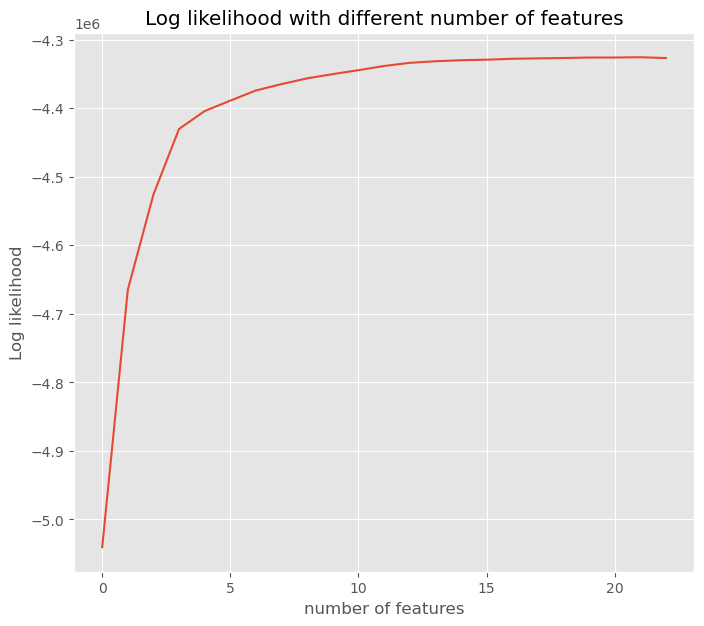

In [22]:
df_sel = df_model.groupby('n_features').max()

fig = plt.figure(figsize=(8,7))
plt.title('Log likelihood with different number of features')
plt.plot(df_sel.index, df_sel.llf)
plt.xlabel('number of features')
plt.ylabel('Log likelihood');

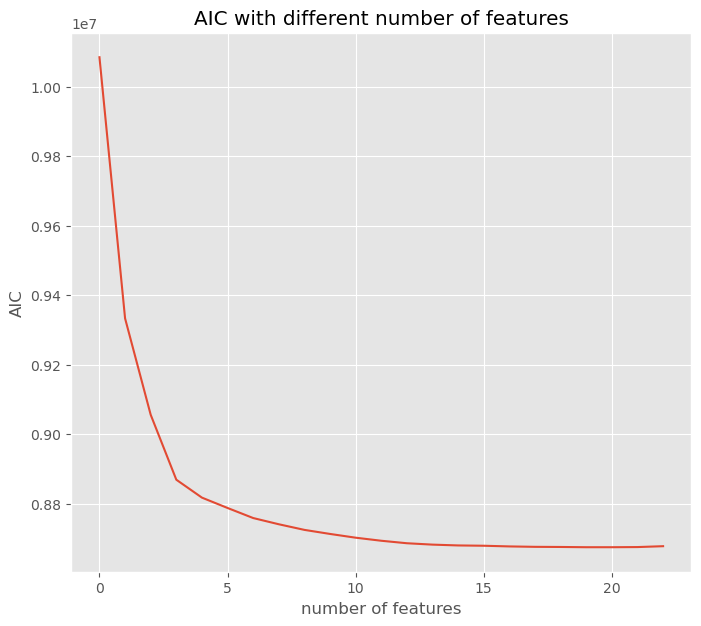

In [23]:
df_sel = df_model.groupby('n_features').min()

fig = plt.figure(figsize=(8,7))
plt.title('AIC with different number of features')
plt.plot(df_sel.index, df_sel.aic)
plt.xlabel('number of features')
plt.ylabel('AIC');

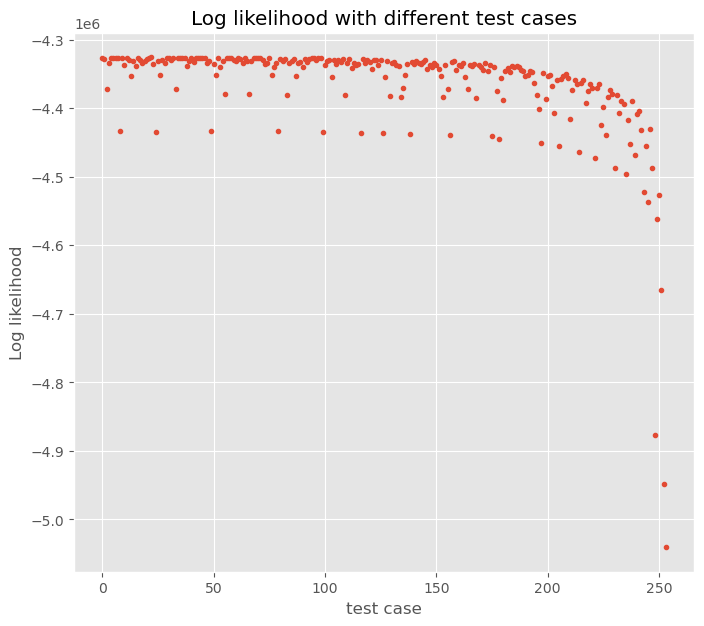

In [24]:
fig = plt.figure(figsize=(8,7))
plt.title('Log likelihood with different test cases')
plt.plot(df_model.llf.values,'.')
plt.xlabel('test case')
plt.ylabel('Log likelihood');

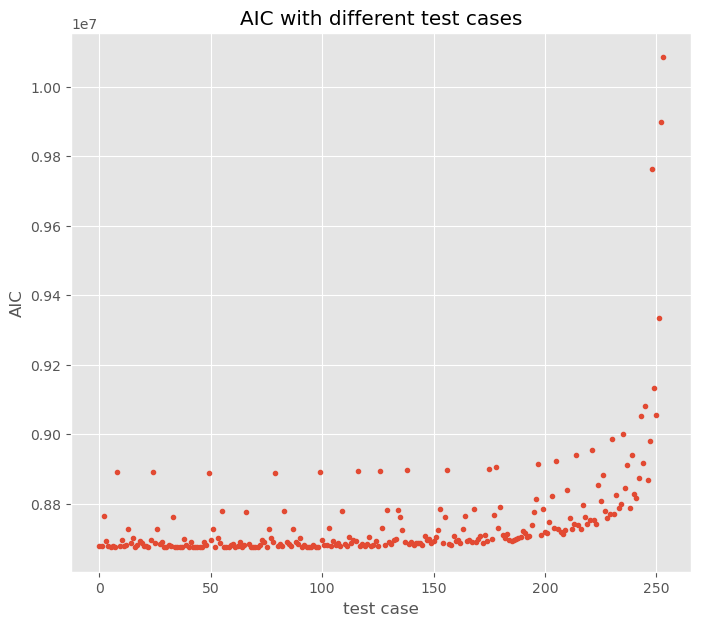

In [25]:
fig = plt.figure(figsize=(8,7))
plt.title('AIC with different test cases')
plt.plot(df_model.aic.values,'.')
plt.xlabel('test case')
plt.ylabel('AIC');

## Bottom up approach
in this approach, we start with an empty set and add one feature into the feature set at each iteration

In [26]:
def bottom_up_each(
    ind_features,
    feature_idxs,
    dfs_data,
    dfs_feature,
    model_class,
    method,
    conditions,
    scaler_col,
):
    feature_idxs = list(feature_idxs)
    all_idxs = list(range(2*len(ind_features)))
    new_idxs = remove_list(all_idxs, feature_idxs)
    res = []
    for idx in new_idxs:
        # add a feature each time
        cur_idxs = feature_idxs + [idx]
        sel_features = map_idx_feature(ind_features, cur_idxs)
        dfr = get_metric(
            model_class,
            method,
            dfs_data,
            dfs_feature,
            sel_features[0],
            sel_features[1],
            conditions,
            scaler_col,
        )
        r = {}
        r["aic"] = dfr["aic"].sum()
        r["llf"] = dfr["llf"].sum()
        r["idxs"] = cur_idxs
        res.append(r)
    return res


In [27]:
import datetime

suffix = datetime.date.today().strftime("%m_%d_%Y")
pickle_name = "feature_selection_bottomup_{}_{}_{}.pickle".format(model_class.__name__,method,suffix)

In [28]:
cur_idxs = []
should_stop=False
n_max = 2*len(ind_features)

# first run 
sel_features = [[],[]]
dfr = get_metric(
    model_class,
    method,
    dfs_data,
    dfs_feature,
    sel_features[0],
    sel_features[1],
    conditions,
    scaler_col,
)
r = {}
r["aic"] = dfr["aic"].sum()
r["llf"] = dfr["llf"].sum()
r["idxs"] = cur_idxs

res_all=[r]
res_steps=[r]

k=0
while len(cur_idxs) < n_max and not should_stop:
    print(k)
    res = bottom_up_each(
        ind_features,
        cur_idxs,
        dfs_data,
        dfs_feature,
        model_class,
        method,
        conditions,
        scaler_col,
    )
    
    # this is the same as one below
    idx=np.argmin([r['aic'] for r in res])
    # idx=np.argmax([r['llf'] for r in res])
    
    cur_idxs = res[idx]['idxs']
    res_all =res_all +res
    res_steps.append(res[idx])
    
    with open(pickle_name, "wb") as output_file:
        pickle.dump([res_all, res_steps], output_file)
    
    k=k+1

In [29]:
for r in res_all:
    r['n_features']=len(r['idxs'])
df_model = pd.DataFrame(res_all).set_index('n_features')

In [30]:
min_idx=np.argmin([r['aic'] for r in res_all])
map_idx_feature(ind_features, res_all[min_idx]['idxs'])

[['UMIs_log',
  'mito_pct',
  'Capbatch',
  'genes_log',
  'ribo_pct',
  'PMI',
  'RIN',
  'UMIs',
  'sex',
  'age',
  'genes'],
 ['mito_pct',
  'Capbatch',
  'PMI',
  'genes',
  'age',
  'UMIs_log',
  'ribo_pct',
  'sex',
  'genes_log',
  'RIN']]

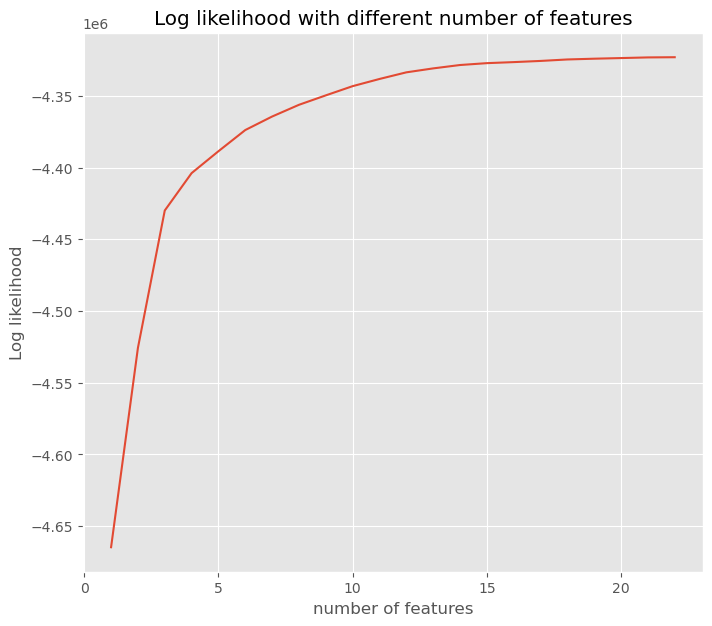

In [31]:
df_sel = df_model.groupby('n_features').max()

fig = plt.figure(figsize=(8,7))
plt.title('Log likelihood with different number of features')
plt.plot(df_sel.index, df_sel.llf)
plt.xlabel('number of features')
plt.ylabel('Log likelihood');

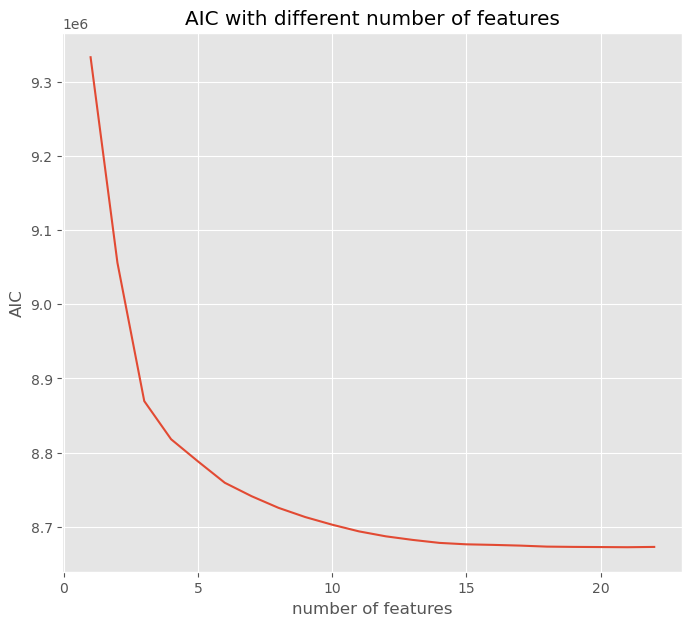

In [32]:
df_sel = df_model.groupby('n_features').min()

fig = plt.figure(figsize=(8,7))
plt.title('AIC with different number of features')
plt.plot(df_sel.index, df_sel.aic)
plt.xlabel('number of features')
plt.ylabel('AIC');

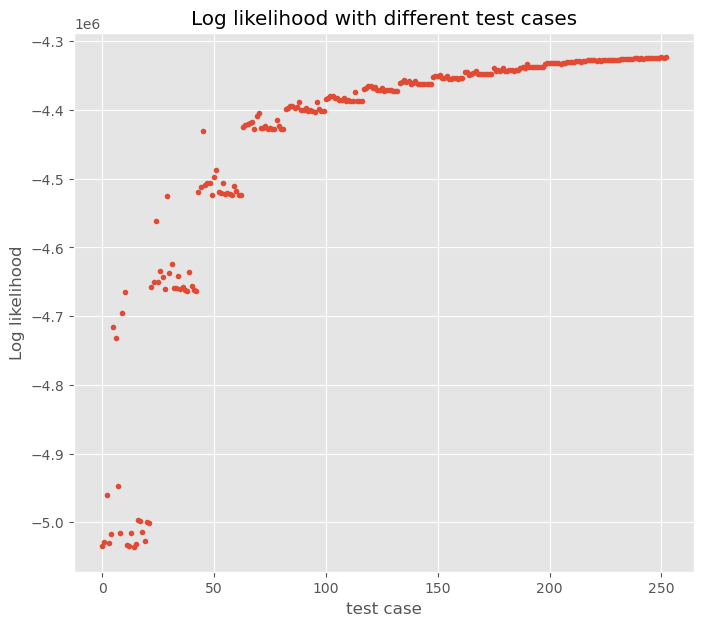

In [33]:
fig = plt.figure(figsize=(8,7))
plt.title('Log likelihood with different test cases')
plt.plot(df_model.llf.values,'.')
plt.xlabel('test case')
plt.ylabel('Log likelihood');

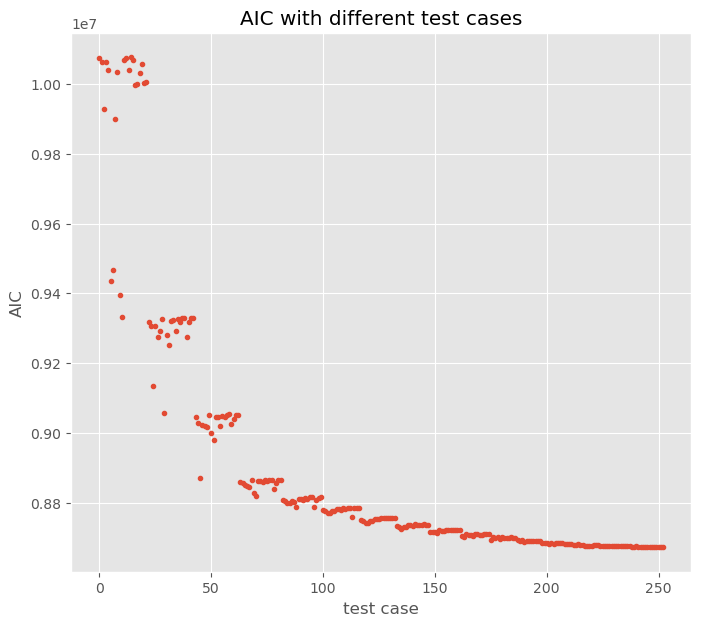

In [34]:
fig = plt.figure(figsize=(8,7))
plt.title('AIC with different test cases')
plt.plot(df_model.aic.values,'.')
plt.xlabel('test case')
plt.ylabel('AIC');